In [3]:
import pandas as pd 
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler



In [4]:
# Read data 

df = pd.read_csv('../../data.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_6416\14438960.py:3: DtypeWarning: Columns (17,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data.csv')


In [5]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Functions for later use

#### Stratified sampling Function

In [6]:
# Stratified sampling

def StratifiedSampling(X,y, test_size=0.2, random_state=42):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, 
                                                        random_state=random_state)
    
    return X_train, X_test, y_train, y_test

### Oversampling function

In [7]:
def Oversampling(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, 
                                                        random_state=random_state)
    # Instantiate the SMOTE object
    smote = SMOTE(random_state=42)
    # Perform SMOTE only on the training data
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    return X_train_balanced, X_test, y_train_balanced, y_test

### evaluate_predictions function
#### for metric presentations

In [8]:
def evaluate_predictions(y_true, y_pred, model_name):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], 
                yticklabels=['Non-default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name)
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, target_names=['Non-default', 'Default'], output_dict=True)

    # Create a summary table
    summary_table = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'ROC-AUC Score': [roc_auc],
        'Precision (Non-default)': [report['Non-default']['precision']],
        'Recall (Non-default)': [report['Non-default']['recall']],
        'F1-score (Non-default)': [report['Non-default']['f1-score']],
        'Precision (Default)': [report['Default']['precision']],
        'Recall (Default)': [report['Default']['recall']],
        'F1-score (Default)': [report['Default']['f1-score']],
    })

    return summary_table

# Data pre-processing

In [9]:
# total_rev_hi_lim 

# Fill missing values in total_rev_hi_lim with Simple Imputer

imputer = SimpleImputer(strategy='median')
total_rev_hi_lim = df['total_rev_hi_lim'].values.reshape(-1,1)
total_rev_hi_lim_imputed = imputer.fit_transform(total_rev_hi_lim)
df['total_rev_hi_lim'] = total_rev_hi_lim_imputed

In [10]:
# home_ownership 

# Remove rows with value ANY

df = df[df['home_ownership'] != 'ANY']
df['home_ownership'].unique()

# Level encoding for home ownership 

home_type = ['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE']  # Unique values for encoding

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(home_type)

# Encode the 'grade' column in the DataFrame
df['home_ownership'] = encoder.transform(df['home_ownership'])


In [11]:
# Purpose 

# Label encoding for purpose

df['purpose'].unique()

purposes = ['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational']

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(purposes)
# Encode the 'grade' column in the DataFrame
df['purpose'] = encoder.transform(df['purpose'])


In [12]:
# sub_grade

# Sort the order of subgrades and do label encoding

subgrades = ['B2', 'C4', 'C5', 'C1', 'B5', 'A4', 'E1', 'F2', 'C3', 'B1', 'D1',
       'A1', 'B3', 'B4', 'C2', 'D2', 'A3', 'A5', 'D5', 'A2', 'E4', 'D3',
       'D4', 'F3', 'E3', 'F4', 'F1', 'E5', 'G4', 'E2', 'G3', 'G2', 'G1',
       'F5', 'G5']

def custom_sort_key(subgrade):
    match = re.match(r'([A-Za-z]+)(\d+)', subgrade)
    letter = match.group(1)
    number = int(match.group(2))
    
    return letter, number

sorted_subgrades = sorted(subgrades, key=custom_sort_key)

# Level encoding for sorted sub-grade 

encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(sorted_subgrades)

# Encode the 'grade' column in the DataFrame
df['sub_grade'] = encoder.transform(df['sub_grade'])

In [13]:
# employment_lengths

employment_lengths = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', 
                        '7 years', '8 years', '9 years', '10+ years', 'nan']

label_encoder = LabelEncoder()

# Fit the LabelEncoder with unique values
label_encoder.fit(employment_lengths)

# Encode the attribute values
df['emp_length'] = label_encoder.transform(df['emp_length'])

In [14]:
# mths_since_last_delinq

df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(-1)

In [15]:
# mths_since_last_record

df['mths_since_last_record'] = df['mths_since_last_record'].fillna(-1)

In [16]:
# revol_util
# Handle missing value with imputer

imputer = SimpleImputer(strategy='mean')

revol_util = df['revol_util'].values.reshape(-1,1)

revol_util_imputed = imputer.fit_transform(revol_util)

df['revol_util'] = revol_util_imputed

In [17]:
# aggregate annual_inc and annual_inc_joint

df.loc[df['application_type'] 
== 'JOINT', 'annual_inc'] = df.loc[df['application_type'] == 'JOINT', 'annual_inc_joint']

df = df.drop('annual_inc_joint', axis=1)

In [18]:
# dti_joint

df.loc[df['application_type'] 
       == 'JOINT', 'dti'] = df.loc[df['application_type'] == 'JOINT', 'dti_joint']
df = df.drop('dti_joint', axis=1)

In [19]:
# verification_status_joint

df.loc[df['application_type'] 
== 'JOINT', 'verification_status'] = df.loc[df['application_type'] == 'JOINT', 'verification_status_joint']
df = df.drop('verification_status_joint', axis=1)

In [20]:
# term 
# Label encoding for term

term = [' 36 months', ' 60 months']  # Unique values for encoding

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(term)

# Encode the 'grade' column in the DataFrame
df['term'] = encoder.transform(df['term'])

In [21]:
# verification_status

veri = ['Not Verified', 'Source Verified', 'Verified']  # Unique values for encoding

encoder = LabelEncoder()

encoder.fit(veri)


df['verification_status'] = encoder.transform(df['verification_status'])

In [22]:
# pymnt_plan

plan = ['n', 'y']  # Unique values for encoding

encoder = LabelEncoder()
encoder.fit(plan)
df['pymnt_plan'] = encoder.transform(df['pymnt_plan'])

In [23]:
# application_type

type = ['INDIVIDUAL', 'JOINT'] # Unique values for encoding

encoder = LabelEncoder()

encoder.fit(type)

df['application_type'] = encoder.transform(df['application_type'])

In [24]:

# initial_list_status

status = ['f', 'w'] # Unique values for encoding

encoder = LabelEncoder()

encoder.fit(status)

df['initial_list_status'] = encoder.transform(df['initial_list_status'])

In [25]:
# Fill missing last credit pull
df['last_credit_pull_d'].fillna("01-01-2016", inplace=True)

In [26]:
# Credit History Length:
# Calculated as: last_credit_pull - earliest_cr_line
def date_difference(date_str1, date_str2):
    # Convert date strings to datetime objects
    date_format = "%d-%m-%Y"
    date1 = datetime.strptime(date_str1, date_format)
    date2 = datetime.strptime(date_str2, date_format)

    # Calculate the difference
    difference = date2 - date1

    # Return the difference in days
    return difference.days

df['credit_history_length'] = df.apply(lambda row: date_difference(row['earliest_cr_line'],
                                         row['last_credit_pull_d']), axis=1)

# Swap the values and column names
df['default_ind'], df['credit_history_length'] = df['credit_history_length'], df['default_ind']
df.rename(columns={'default_ind': 'credit_history_length', 'credit_history_length': 'default_ind'}, 
                    inplace=True)


In [27]:
# Drop not usable attributes 

remove_col = [
    'id',
    'member_id',
    'emp_title',
    'issue_d',
    'desc',
    'title',
    'zip_code',
    'addr_state',
    'earliest_cr_line',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'next_pymnt_d',
    'last_credit_pull_d',
    'collections_12_mths_ex_med',
    'mths_since_last_major_derog',
    'policy_code',
    'tot_coll_amt',
    'tot_cur_bal', 
    'open_acc_6m',
    'open_il_6m', 
    'open_il_12m', 
    'open_il_24m', 
    'mths_since_rcnt_il', 
    'total_bal_il', 
    'il_util', 
    'open_rv_12m' ,
    'open_rv_24m', 
    'max_bal_bc', 
    'all_util', 
    'inq_fi', 
    'total_cu_tl', 
    'inq_last_12m',
    'grade'
]

df = df.drop(remove_col, axis=1)

## New feature using user defined transformer

In [28]:
class CreditUtilizationRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, include=True):
        self.revol_bal_col = 'revol_bal'
        self.annual_inc_col = 'annual_inc'
        self.installment_col = 'installment'
        self.total_rec_prncp_col = 'total_rec_prncp'
        self.funded_amnt_col = 'funded_amnt'

        self.include_rev_to_inc_ratio = include
        self.include_loan_to_inc_ratio = include
        self.include_repayment_progress = include


    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Find index of columns
        revol_bal_ix = np.where(X.columns == self.revol_bal_col)[0][0]
        annual_inc_ix = np.where(X.columns == self.annual_inc_col)[0][0]
        installment_ix = np.where(X.columns == self.installment_col)[0][0]
        total_rec_prncp_ix = np.where(X.columns == self.total_rec_prncp_col)[0][0]
        funded_amnt_ix = np.where(X.columns == self.funded_amnt_col)[0][0]

        # Calculate the Revolving Credit Balance to Annual Income Ratio.
        rev_to_inc_ratio = X.iloc[:, revol_bal_ix] / X.iloc[:, annual_inc_ix]

        # Calculate the Loan Payment-to-Income Ratio.
        loan_to_inc_ratio = X.iloc[:, installment_ix] / (X.iloc[:, annual_inc_ix] / 12)

        # Calculate the Repayment Progress.
        repayment_progress = (X.iloc[:, total_rec_prncp_ix] / X.iloc[:, funded_amnt_ix]) * 100

        # Create a copy of the original DataFrame to avoid modifying it directly
        X_transformed = X.copy()

        # Add the new columns to the DataFrame using .loc
        if self.include_rev_to_inc_ratio:
            X_transformed.loc[:, 'Rev_to_Inc_Ratio'] = rev_to_inc_ratio

        if self.include_loan_to_inc_ratio:
            X_transformed.loc[:, 'Loan_Payment_to_Income_Ratio'] = loan_to_inc_ratio

        if self.include_repayment_progress:
            X_transformed.loc[:, 'Repayment_Progress'] = repayment_progress

        return X_transformed


## Feature selection

In [29]:
# Define the features (subset of columns from the original dataset)
selected_features = [
    'collection_recovery_fee'   ,                  
    'acc_now_delinq' ,                                    
    'funded_amnt'   ,               
    'funded_amnt_inv'   ,            
    'mths_since_last_record' ,       
    'delinq_2yrs'   ,                          
    'dti'            ,              
    'mths_since_last_delinq'  ,       
    'emp_length',                      
    'pub_rec'   ,                  
    'revol_bal'    ,                                
    'credit_history_length'  ,        
    'term'   ,                       
    'home_ownership' ,                                
    'total_rev_hi_lim'  ,              
    'total_pymnt'      ,                     
    'total_pymnt_inv'  ,              
    'purpose'   ,                   
    'revol_util'   ,                 
    'total_rec_int'   ,               
    'inq_last_6mths'  ,              
    'total_rec_prncp' ,                        
    'sub_grade'        ,             
    'total_rec_late_fee'   ,          
    'int_rate'   ,                    
    'out_prncp_inv'  ,                 
    'out_prncp'   ,                       
    'recoveries'                     
]


# Define the features (subset of columns from the original dataset)
# selected_features = ['recoveries', 'collection_recovery_fee', 'out_prncp', 'out_prncp_inv', 'sub_grade', 'revol_bal', 'annual_inc', 'installment', 'total_rec_prncp', 'funded_amnt']

# Create the feature matrix X by selecting the columns from the original dataset
X_before_transformed = df[selected_features]
y = df['default_ind']

#### StratifiedShuffleSplit Sampling

In [30]:
before_X_train, before_X_test, before_y_train, before_y_test = StratifiedSampling(X_before_transformed, y)

#### Visualisation of Test and Train shape

In [31]:
print("before_X_train shape:", before_X_train.shape)
print("before_X_test shape:", before_X_test.shape)
print("before_y_train shape:", before_y_train.shape)
print("before_y_test shape:", before_y_test.shape)

before_X_train shape: (684772, 28)
before_X_test shape: (171194, 28)
before_y_train shape: (684772,)
before_y_test shape: (171194,)


#### Result: Significantly imbalanced class distribution

#### Solution: Have to apply class balancing techniques (e.g. oversampling/SMOTE, or Class-Weighted approach) just before Model training



### For Fine-Tuning


#### Add User-defined Transformer Features to X

In [32]:
# Decide to use new generated features

transformer_with_features = CreditUtilizationRatioTransformer(include=True)

# Apply the transformer to add the new features to df.
new_df = transformer_with_features.transform(df)
new_selected_features = selected_features

new_selected_features.append('Repayment_Progress')
new_selected_features.append('Loan_Payment_to_Income_Ratio')
new_selected_features.append('Rev_to_Inc_Ratio')
X_transformed = new_df[new_selected_features]
# new_y1 = NB_df['default_ind']

#### StratifiedShuffleSplit Re-Sampling

In [33]:
Balanced_X_train, Balanced_X_test, Balanced_y_train, Balanced_y_test = StratifiedSampling(X_transformed, y)

#### Visualisation of Test and Train shape

In [34]:
print("Balanced_X_train shape:", Balanced_X_train.shape)
print("Balanced_X_test shape:", Balanced_X_test.shape)
print("Balanced_y_train shape:", Balanced_y_train.shape)
print("Balanced_y_test shape:", Balanced_y_test.shape)

Balanced_X_train shape: (684772, 31)
Balanced_X_test shape: (171194, 31)
Balanced_y_train shape: (684772,)
Balanced_y_test shape: (171194,)


# Model selections and training

# Decision Tree Model


## 1. Fresh Round of Training

#### 1a: Basic Decision Tree Model Training

In [35]:
# Create a Decision Tree Classifier with random state = 42
DT_classifier = DecisionTreeClassifier()

# Train the classifier
DT_classifier.fit(before_X_train, before_y_train)

# Make predictions on the test set
DT_y_pred_basic = DT_classifier.predict(before_X_test)

#### 1b: Basic decision tree model + SMOTE

In [36]:
# Instantiate the SMOTE object
smote = SMOTE(random_state=42)

# Perform SMOTE only on the training data
DT_X_train_balance, DT_X_test, DT_y_train_balance, DT_y_test = Oversampling(X_before_transformed, y)

# Create a Decision Tree Classifier with random state = 42
DT_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier
DT_classifier.fit(DT_X_train_balance, DT_y_train_balance)

# Make predictions on the test set
DT_y_pred_basic_smote = DT_classifier.predict(DT_X_test)


## 2) Fine tune DT model

#### 2a: Training Decision Tree Model with hyperparameters

In [37]:
DT_classifier = DecisionTreeClassifier(criterion='entropy',splitter = 'best', max_depth = 10, 
                                       min_samples_split = 10, min_samples_leaf = 4, 
                                       class_weight='balanced', random_state=42)

DT_classifier.fit(DT_X_train_balance, DT_y_train_balance)

DT_y_pred = DT_classifier.predict(DT_X_test)


#### Training model - Pre prune

In [38]:
# Define the range of ccp_alpha to test
DT_param_grid = {'max_depth': range(3, 9), 'criterion': ['gini', 'entropy', 'log_loss'] }

# Initialize the DT classifier
DT_classifier_prepruned = DecisionTreeClassifier(splitter = 'best', min_samples_split = 10, min_samples_leaf = 4, class_weight='balanced', random_state=42)

# Use GridSearchCV or RandomizedSearchCV for hyperparameter tuning
# For GridSearchCV:
grid_search = GridSearchCV(DT_classifier_prepruned, DT_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
best_pruned_model = grid_search.fit(DT_X_train_balance, DT_y_train_balance)

DT_y_pred_prepruned = best_pruned_model.predict(DT_X_test)

#### 2b: Training Decision Tree Model with post-pruning

In [39]:
# Define the range of ccp_alpha to test
DT_param_grid = {'ccp_alpha': range(0, 5)}

# Initialize the DT classifier
DT_classifier_postpruned = DecisionTreeClassifier(max_depth=5, random_state=42)

# Use GridSearchCV or RandomizedSearchCV for hyperparameter tuning
# For GridSearchCV:
grid_search = GridSearchCV(DT_classifier_postpruned, DT_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
best_pruned_model = grid_search.fit(DT_X_train_balance, DT_y_train_balance)

DT_y_pred_postpruned = best_pruned_model.predict(DT_X_test)

## 3) Evaluate the best model


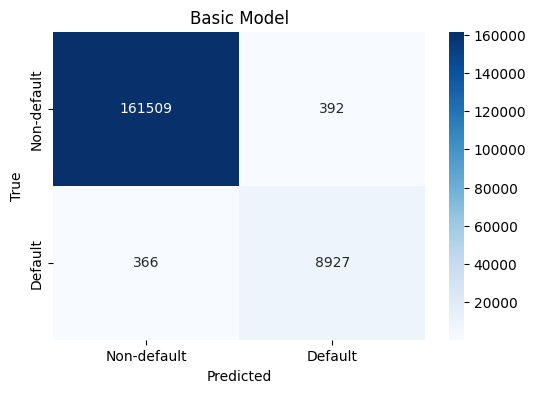

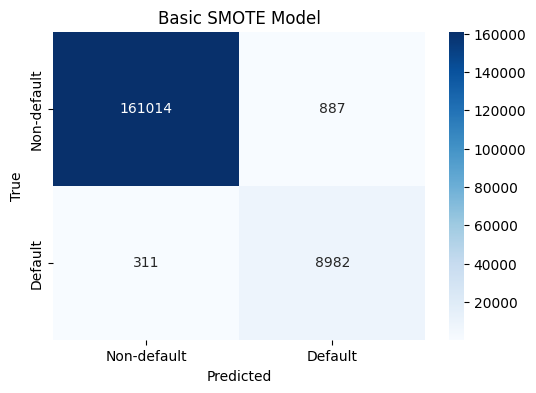

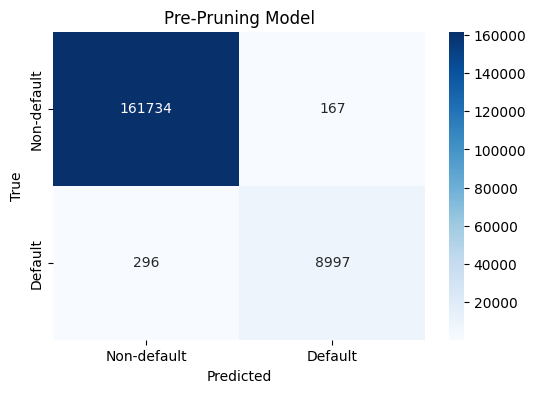

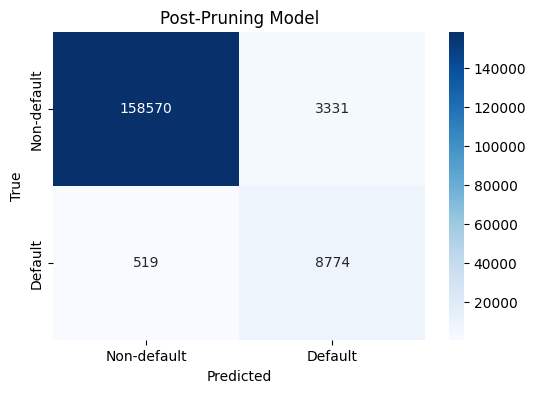

                Model  Accuracy  ROC-AUC Score  Precision (Non-default)  \
0         Basic Model  0.995572       0.979097                 0.997739   
1   Basic SMOTE Model  0.993002       0.980528                 0.998072   
2   Pre-Pruning Model  0.997295       0.983558                 0.998173   
3  Post-Pruning Model  0.977511       0.961789                 0.996738   

   Recall (Non-default)  F1-score (Non-default)  Precision (Default)  \
0              0.997579                0.997659             0.957935   
1              0.994521                0.996294             0.910123   
2              0.998969                0.998571             0.981777   
3              0.979426                0.988006             0.724824   

   Recall (Default)  F1-score (Default)  
0          0.960616            0.959274  
1          0.966534            0.937480  
2          0.968148            0.974915  
3          0.944152            0.820077  


In [45]:
DT_basic_summary = evaluate_predictions(Balanced_y_test, DT_y_pred_basic, "Basic Model")
DT_basic_SMOTE_summary = evaluate_predictions(DT_y_test, DT_y_pred_basic_smote, "Basic SMOTE Model")
DT_prepruned_summary = evaluate_predictions(DT_y_test, DT_y_pred_prepruned, "Pre-Pruning Model")
DT_postpruned_summary = evaluate_predictions(DT_y_test, DT_y_pred_postpruned, "Post-Pruning Model")


# Combine all summaries into one DataFrame
DT_all_summaries = pd.concat([DT_basic_summary,DT_basic_SMOTE_summary, DT_prepruned_summary, DT_postpruned_summary], ignore_index=True)
# Display the summary table
print(DT_all_summaries)

#### Conclusion: Since Decision Tree using SMOTE have the best scores across almost all metrics, therefore it is best to use this approach